In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# Any results you write to the current directory are saved as output.

In [55]:
TRAIN_PATH = os.path.join("", "BBC News Train.csv")

#Load the data using pandas : Create a DataFrame named df, that contains the training data 
df = pd.read_csv(TRAIN_PATH)

In [56]:
df['category_id'] = df['Category'].factorize()[0]

In [57]:
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')

In [58]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
id_to_category

{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Text).toarray() # Remaps the words in the 1490 articles in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = df.category_id                           # represents the category of each of the 1490 articles


In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=100, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=30),
]


In [61]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty


In [62]:
#For each Algorithm 
for model in models:
    model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))


In [63]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


In [65]:
cv_df.groupby('model_name').accuracy.mean()


model_name
LogisticRegression        0.975168
MultinomialNB             0.972483
RandomForestClassifier    0.955705
Name: accuracy, dtype: float64

In [40]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.939597
1,RandomForestClassifier,1,0.939597
2,RandomForestClassifier,2,0.973154
3,RandomForestClassifier,3,0.963087
4,RandomForestClassifier,4,0.963087
5,MultinomialNB,0,0.969799
6,MultinomialNB,1,0.959732
7,MultinomialNB,2,0.983221
8,MultinomialNB,3,0.979866
9,MultinomialNB,4,0.969799


In [41]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=42)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)


Text(0.5, 15.0, 'Predicted')

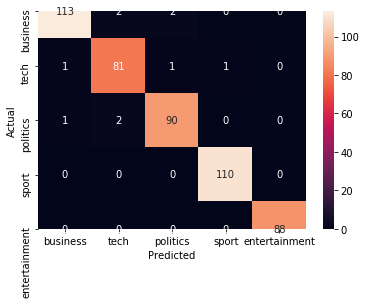

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [47]:
TEST_PATH = os.path.join("", "BBC News Test.csv")

#Load the data using pandas : Create a DataFrame
test_df = pd.read_csv(TEST_PATH)


In [48]:
test_features = tfidf.transform(test_df.Text.tolist())

Y_pred = model.predict(test_features)

# Y_pred

In [49]:
Y_pred_name =[]
for cat_id in Y_pred :
    Y_pred_name.append(id_to_category[cat_id])


In [50]:
submission = pd.DataFrame({
        "ArticleId": test_df["ArticleId"],
        "Category": Y_pred_name
    })


In [51]:
submission.to_csv('submission.csv', index=False)